In [664]:
import numpy as np
from cadCAD.configuration import append_configs
from cadCAD.configuration.utils import bound_norm_random, ep_time_step, config_sim
import matplotlib.pyplot as plt



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
np.random.seed(42)
n_tokens = 8
n_makers = 10
token_prices = np.random.randint(1,1000,n_tokens)/3
CMN_minted = 1000
CMN_ownership = CMN_minted*np.random.dirichlet(np.ones(n_makers),size=1)
past_trade_volumes = np.random.randint(100,1000,n_tokens)/100
past_trade_volumes/=np.sum(past_trade_volumes)
CMN_votes = np.zeros((n_makers, n_tokens))

#system starts in equilibrium
for i in range(n_makers):
    CMN_votes[i,:] = past_trade_volumes/np.sum(past_trade_volumes)

target_ratios = np.sum(CMN_votes*CMN_ownership.reshape(n_makers, 1),0)/CMN_minted
deposit_balances = np.random.randint(1,1000)*target_ratios/token_prices

current_trade_volumes = past_trade_volumes.copy()
# current_trade_volumes /= np.sum(current_trade_volumes)

initial_conditions = {
    #initial deposit of each coin is proportional to its trading volume
    'revoting': True,
    'n_tokens': n_tokens,
    'n_makers': n_makers,
    'token_prices': token_prices,
    'CMN_minted': CMN_minted,
    'CMN_ownership': CMN_ownership,
    'past_trade_volumes': past_trade_volumes,
    'current_trade_volumes': current_trade_volumes,
    'target_ratios': target_ratios,
    'CMN_votes': CMN_votes,
    'deposit_balances': deposit_balances,
    'fees_gathered': np.zeros(n_makers),
    'arbitrageurs_revenue': 0,
    'accumulated_slippage': 0
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
n_timepoints = 5000
n_runs = 1
simulation_parameters = {
    'T': range(n_timepoints),
    'N': n_runs,
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
def get_current_timestep(cur_substep, s):
    if cur_substep == 1:
        return s['timestep']+1
    return s['timestep']

def random_trader(params, step, sL, s):
    #It models normal traders, i.e. such that perform trades just for the sake of aquiring a different token.
    #They do not try to game the system.
    v = s['current_trade_volumes']
    #traders have average pacing in the system
    if get_current_timestep(step, s)%20==0:
        #choose what pair to trade
        i, o = np.random.choice(s['n_tokens'],2, replace = False)
        #choose the traded amount
        amount = (v[i]*v[o])/(np.mean(v)**2)*s['deposit_balances'][i]*np.random.randint(1,1000)/10000
        return({'pair': (i,o), 'amount': amount})
    else: 
        return({'pair': (0,0), 'amount': 0})

def arbitrageur(params, step, sL, s):
    #arbitrageurs are the fastest actors and always execute trade on the most profitable pair (if any profitable pair exists)
    b = s['deposit_balances']
    w = s['target_ratios']
    p = s['token_prices']
    n_tokens = s['n_tokens']
    #calculate spot price of every token. If it is not very close to actual price of the token (i.e., on external markets),
    #then it is an arbitrage opportunity. 
    sp = w/b
    ratio = sp/p
    if np.max(ratio)/np.min(ratio) > 1.05:
        i, o = np.argmax(ratio), np.argmin(ratio)
        amount = b[i]*0.01
        return({'pair_a': (i,o), 'amount_a': amount})
    else:
        return({'pair_a': (0,0), 'amount_a': 0})

def revoting_maker(params, step, sL, s):
    #market makers can game their fees by changing the distribution of their votes. As its a competitive market, 
    #these actions are also very fast 
    n_makers = s['n_makers']
    n_tokens = s['n_tokens']
    #randomly chosen market maker will be the first to adapt to the new volumes
    m = np.random.randint(n_makers)
    
    v = s['current_trade_volumes']
    p = s['token_prices']

    CMN_votes = s['CMN_votes']
    
    undervoted_tokens = np.mean(CMN_votes,0)/v/p
    if s['revoting'] and np.max(undervoted_tokens) > 1.05:
        delta_votes = undervoted_tokens
    else:
        delta_votes = np.ones(n_tokens)
    return({'delta_votes': delta_votes, 'maker': m})

def market_fluctuation(params, step, sL, s):
    #current traded volumes are changing due to market fluctuations
    n_tokens = s['n_tokens']
    if get_current_timestep(step, s)%300==0:
        fluctuation_v = (np.random.dirichlet(np.ones(n_tokens),size=1)[0,:]-1/n_tokens)/20
        fluctuation_p = np.ones(n_tokens) + np.random.dirichlet(np.ones(n_tokens), size = 1)[0,:]
        fluctuation_p /= (np.prod(fluctuation_p))**(1/float(n_tokens))
#         print(fluctuation_p)
        return({'fluctuation_v': fluctuation_v, 'fluctuation_p': fluctuation_p})
    else:
        return({'fluctuation_v': np.zeros(n_tokens), 'fluctuation_p': np.ones(n_tokens)})

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def update_slippage(params, step, sL, s, _input):
    b = s['deposit_balances']
    w = s['target_ratios']
    p = s['token_prices']
    
    #execute normal trades (we don't care about slippage of arbitrageurs)
    i,o = _input['pair']
    A_i =  _input['amount']
    A_o = b[o]*(1 - (b[i]/(b[i]+A_i))**(w[i]/w[o]))
    A_o_optimal = A_i*((b[o]/w[o])/(b[i]/w[i]))
    slippage = s['accumulated_slippage']
    slippage += (A_o_optimal-A_o)*p[o]
    return ('accumulated_slippage', slippage)

def update_votes(params, step, sL, s, _input):
    votes = s['CMN_votes']
    delta = _input['delta_votes']
    m = _input['maker']
    votes[m,:] /= delta
#     votes[m,:] /= np.sum(votes[m,:])
    return ('CMN_votes', votes)

def update_target_ratios(params, step, sL, s, _input):
    votes = s['CMN_votes']
    ratios = s['target_ratios']
    CMN_ownership = s['CMN_ownership']
    n_makers = s['n_makers']
    CMN_minted = s['CMN_minted']
    CMN_votes = s['CMN_votes']
    ratios = np.sum(CMN_votes*CMN_ownership.reshape(n_makers, 1),0)/CMN_minted
    return ('target_ratios', ratios)

def update_current_trade_volumes(params, step, sL, s, _input):
    v = s['current_trade_volumes']
    fluctuation = _input['fluctuation_v']
    n_tokens = s['n_tokens']
#     print('                         ',v.shape, fluctuation.shape)
    for i in range(8):
        v[i] += fluctuation[i]        
    #volumes can't be negative
    v = np.abs(v)
    v /= np.sum(v)
    return ('current_trade_volumes', v)

def update_prices(params, step, sL, s, _input):
    v = s['token_prices'].reshape(1,n_tokens)
    fluctuation = _input['fluctuation_p']
    v *= np.array(fluctuation)
    #volumes can't be negative
    v = np.abs(v)
    v /= np.sum(v)
    return ('current_trade_volumes', v.reshape(8))

def update_balances(params, step, sL, s, _input):
    b = s['deposit_balances']
    w = s['target_ratios']
    
    #execute normal trades
    i,o = _input['pair']
    A_i =  _input['amount']
    A_o = b[o]*(1 - (b[i]/(b[i]+A_i))**(w[i]/w[o]))
    b[i] += A_i
    b[o] -= A_o
    
    #execute arbitrageurs trades
    i,o = _input['pair_a']
    A_i =  _input['amount_a']
    A_o = b[o]*(1 - (b[i]/(b[i]+A_i))**(w[i]/w[o]))
    b[i] += A_i
    b[o] -= A_o
    return ('deposit_balances', b)

def update_volumes(params, step, sL, s, _input):
    b = s['deposit_balances']
    w = s['target_ratios']
    v = s['past_trade_volumes']
    
    #execute normal trades
    i,o = _input['pair']
    A_i =  _input['amount']
    A_o = b[o]*(1 - (b[i]/(b[i]+A_i))**(w[i]/w[o]))
    v[i] += A_i
    v[o] += A_o
    
    #execute arbitrageurs trades
    i,o = _input['pair_a']
    A_i =  _input['amount_a']
    A_o = b[o]*(1 - (b[i]/(b[i]+A_i))**(w[i]/w[o]))
    v[i] += A_i
    v[o] += A_o
    return ('past_trade_volumes', v)

def update_fees_gathered(params, step, sL, s, _input):
    b = s['deposit_balances']
    w = s['target_ratios']
    f = s['fees_gathered']
    p = s['token_prices']

    #execute normal trades
    i,o = _input['pair']
    A_i =  _input['amount']
    A_o = b[o]*(1 - (b[i]/(b[i]+A_i))**(w[i]/w[o]))
    fees_i = A_o*0.9985*p[o]*(CMN_votes[:,i]/np.sum(CMN_votes[:,i]))
    fees_o = A_o*0.9985*p[o]*(CMN_votes[:,o]/np.sum(CMN_votes[:,o]))
    f += fees_i
    f += fees_o
    
    #execute arbitrageurs trades
    i,o = _input['pair_a']
    A_i =  _input['amount_a']
    A_o = b[o]*(1 - (b[i]/(b[i]+A_i))**(w[i]/w[o]))
    fees_i = A_o*0.9985*p[o]*(CMN_votes[:,i]/np.sum(CMN_votes[:,i]))
    fees_o = A_o*0.9985*p[o]*(CMN_votes[:,o]/np.sum(CMN_votes[:,o]))
    f += fees_i
    f += fees_o
    return ('fees_gathered', f)

def update_arbitrageurs_revenue(params, step, sL, s, _input):
    b = s['deposit_balances']
    w = s['target_ratios']
    f = s['fees_gathered']
    p = s['token_prices']
    r = s['arbitrageurs_revenue']
    
    #execute arbitrageurs trades
    i,o = _input['pair_a']
    A_i =  _input['amount_a']
    A_o = b[o]*(1 - (b[i]/(b[i]+A_i))**(w[i]/w[o]))
    A_o *= 0.997 #0.3% fee stays in the system
    r += A_o*p[o] - A_i*p[i]
    return ('arbitrageurs_revenue', r)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'random_trader': random_trader,
            'arbitrageur': arbitrageur,
            'market_fluctuation': market_fluctuation,
            'revoting_maker': revoting_maker
        },
        'variables': { # The following state variables will be updated simultaneously
            'deposit_balances': update_balances,
            'past_trade_volumes': update_volumes,
            'fees_gathered': update_fees_gathered,
            'arbitrageurs_revenue': update_arbitrageurs_revenue,
            'current_trade_volumes' : update_current_trade_volumes,
            'CMN_votes': update_votes,
            'target_ratios' : update_target_ratios,
            'accumulated_slippage': update_slippage,
            'token_prices': update_prices
        }
    }
]

def plot_slippage(slippage, n_timepoints, n_runs):
    slip = np.zeros((n_timepoints, n_runs))
    for i in range(n_runs):
        slip[:,i] = slippage[i*n_timepoints:(i+1)*n_timepoints]
    slip = slip[200:,:]-slip[200,:] #there is some weird rebalancing going on during the initialization
    plt.plot(slip)
    plt.show()

In [665]:
from cadCAD.configuration import Configuration
import config
from cadCAD import configs

exec_mode = ExecutionMode()
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# The configurations above are then packaged into a `Configuration` object
# initial_conditions['revoting'] = 'False'
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)

slip = np.stack(df['accumulated_slippage'].values, axis=0)
accumulated_slippage_with_revoting = slip[200:]-slip[200] #some weird rebalancing happens at the start



                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7f47c1eecba8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f47c1eecba8>]


In [666]:

initial_conditions = {
    #initial deposit of each coin is proportional to its trading volume
    'revoting': False,
    'n_tokens': n_tokens,
    'n_makers': n_makers,
    'token_prices': token_prices,
    'CMN_minted': CMN_minted,
    'CMN_ownership': CMN_ownership,
    'past_trade_volumes': past_trade_volumes,
    'current_trade_volumes': current_trade_volumes,
    'target_ratios': target_ratios,
    'CMN_votes': CMN_votes,
    'deposit_balances': deposit_balances,
    'fees_gathered': np.zeros(n_makers),
    'arbitrageurs_revenue': 0,
    'accumulated_slippage': 0
}
exec_mode = ExecutionMode()
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

%matplotlib inline
import pandas as pd
df = pd.DataFrame(raw_result)

slip = np.stack(df['accumulated_slippage'].values, axis=0)
accumulated_slippage_without_revoting = slip[200:]-slip[200] #some weird rebalancing happens at the start


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7f47c1ccc748>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f47c1ccc748>]


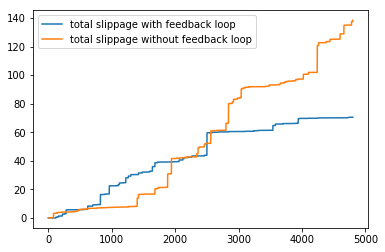

In [673]:
plt.plot(accumulated_slippage_with_revoting, label = 'total slippage with feedback loop')
plt.plot(accumulated_slippage_without_revoting, label = 'total slippage without feedback loop')
plt.legend()